# Homework 10

In [62]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
import sklearn.tree as tr
import sklearn.ensemble as ens
import sklearn.linear_model as slm
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [63]:
nfl = pd.read_csv("./NFL_play_by_play_2022.csv.gz")
nfl.shape

(50147, 340)

These data record play-by-play information for all games in the 2022 National Football League (NFL) season. These data were downloaded using the `nflverse` package for the R programming language (another statistics and data science environment), lightly edited, and saved in a tabular format for us to use in Python.

There are many measurements for each play, some of which are computed values from `nflverse`. Here's a brief list using the data dictionary.

In [64]:
nfl_data_dictionary = pd.read_csv("./NFL_play_by_play_data_dictonary.csv", index_col = "Field")
nfl_data_dictionary.loc[["play_id", "game_id", "home_team", "away_team", "posteam",
                         "defteam", "yardline_100", "down", "ydstogo",
                        "touchdown", "play_type"]]

,Description,Type
Field,,
play_id,Numeric play id that when used with game_id and drive provides the unique identifier for a single play.,numeric
game_id,Ten digit identifier for NFL game.,character
home_team,String abbreviation for the home team.,character
away_team,String abbreviation for the away team.,character
posteam,String abbreviation for the team with possession.,character
defteam,String abbreviation for the team on defense.,character
yardline_100,Numeric distance in the number of yards from the opponent's endzone for the posteam.,numeric
down,The down for the given play.,numeric
ydstogo,Numeric yards in distance from either the first down marker or the endzone in goal down situations.,numeric


## Question 1

### Part (a)

For this section, we will aggregate the individual plays into games.

Use `groupby` on `"game_id"` to aggregate(`.agg`) the games. Include the following columns:

```
{"home_score": "first",
 "away_score": "first",
 "week": "first",
 "home_team": "first",
 "away_team": "first",
 "roof": "first",
 "wind": "median",
 "temp": "median",
 "play_id": "size"}
```

Call the result `games`. Demonstrate using a plot that shows the number of games played each week. The season is composed of a regular season in which all teams play and post season playoffs in which only some teams play. Using the plot, how many weeks are in a regular season?



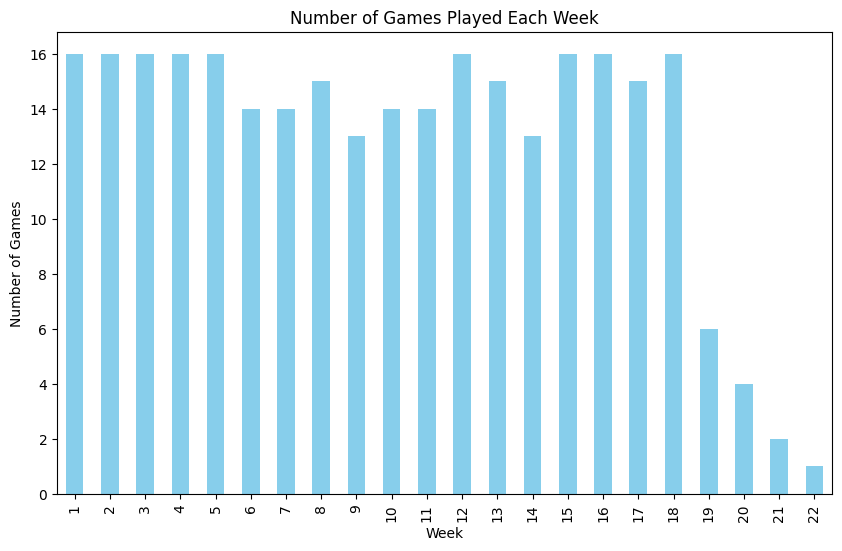

Regular season is composed of 18 weeks.


In [65]:
games = nfl.groupby("game_id").agg({
    "home_score": "first",
    "away_score": "first",
    "week": "first",
    "home_team": "first",
    "away_team": "first",
    "roof": "first",
    "wind": "median",
    "temp": "median",
    "play_id": "size"
}).reset_index()

# Plotting games per week
games_per_week = games["week"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
games_per_week.plot(kind='bar', color="skyblue")
plt.title("Number of Games Played Each Week")
plt.xlabel("Week")
plt.ylabel("Number of Games")
plt.show()


print(f"Regular season is composed of 18 weeks.")



### Part (b)

Some people think teams benefit from playing at home. Compute the difference between the home team score and the away team score and store it as a new column (call it `"home_away_score"`).

Plot this new variable. Do you see evidence of this claim?


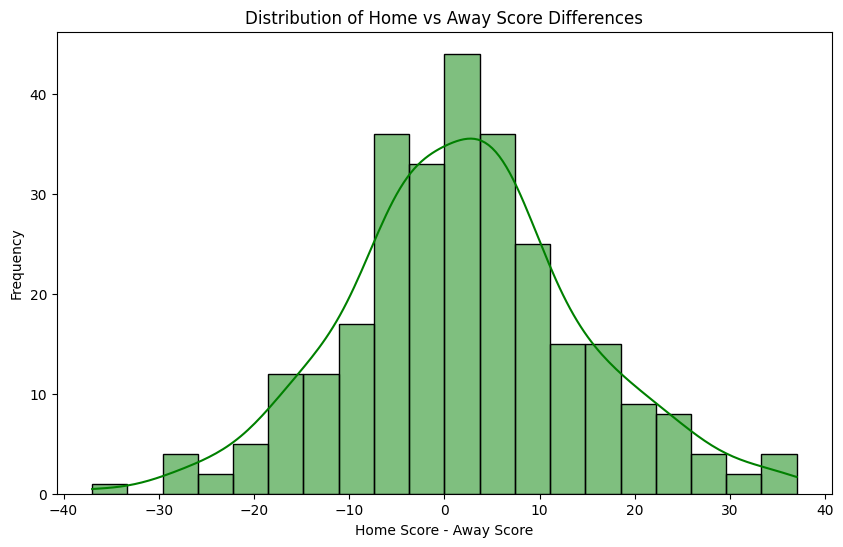

mean: 2.0880281690140845


In [66]:
#### Part (b): Home vs Away Score Difference
games["home_away_score"] = games["home_score"] - games["away_score"]

# Plot
plt.figure(figsize=(10, 6))
sb.histplot(games["home_away_score"], kde=True, color="green", bins=20)
plt.title("Distribution of Home vs Away Score Differences")
plt.xlabel("Home Score - Away Score")
plt.ylabel("Frequency")
plt.show()

print("mean:", games['home_away_score'].mean())


As the mean is positive there is slight evidence for this claim, however based on the graph it does not seem to have an incredible impact.


### Part (c)

Suppose these games represent a sample from all possible games that could have been played in 2022. Let $X$ be the home and away teams' score difference. Test the hypothesis:

$H_0: E(X) = 0$ against $H_1: E(X) \ne 0$

at the 5% level or create a 95% confidence interval for $E(X)$. What do you conclude about this hypothesis. Interpret it as evidence for or against the claim of home field advantage.



In [67]:
# Calculate the home_away_score
games["home_away_score"] = games["home_score"] - games["away_score"]

# Mean and standard error
mean_diff = games["home_away_score"].mean()
std_error = games["home_away_score"].std() / np.sqrt(len(games))

ci_lower = mean_diff - 1.96 * std_error
ci_upper = mean_diff + 1.96 * std_error
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")



95% Confidence Interval: (0.6435872468414123, 3.5324690911867567)


As the interval does not contain 0 we reject the Null Hypothesis, meaning there is a home field advantage.



### Part (d)

One theory of home game advantage states that teams that play outdoors in cold weather are acclimated to cold weather, while teams that do not play outdoors will not perform as well in outdoor games.

We will ask a slightly simpler question and ask if the average home and away difference in outdoor games is larger than in indoor games.

To do this, we need to identify if a game is played outdoors. Investigate the `"roof"` column and create a new column (call it `"is_outdoors"`) that has the value True if the games is played outdoors and False otherwise.


Use a box plot to explore whether games played outdoors have different home and away score differences than non-outdoor games.



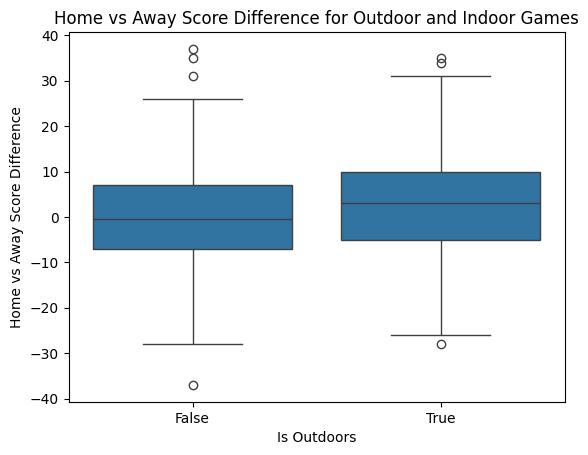

In [68]:
games["is_outdoors"] = games["roof"].str.lower().isin(["open", "outdoors"])
sb.boxplot(x="is_outdoors", y="home_away_score", data=games)
plt.title("Home vs Away Score Difference for Outdoor and Indoor Games")
plt.xlabel("Is Outdoors")
plt.ylabel("Home vs Away Score Difference")
plt.show()



### Part (e)

Perform a difference of means hypothesis test to the the hypothesis that the average score difference is the same for both outdoors and non-outdoors games against the alternative that it is different. At the 5% level (or using a 95% confidence interval) what do you conclude?


In [69]:
# Compute means and variances for outdoor and non-outdoor games
outdoor = games[games["is_outdoors"] == True]
non_outdoor = games[games["is_outdoors"] == False]

mean_outdoor = outdoor["home_away_score"].mean()
mean_non_outdoor = non_outdoor["home_away_score"].mean()

var_outdoor = outdoor["home_away_score"].var()
var_non_outdoor = non_outdoor["home_away_score"].var()

n_outdoor = len(outdoor)
n_non_outdoor = len(non_outdoor)

# Calculate t-statistic
t_stat = (mean_outdoor - mean_non_outdoor) / np.sqrt(var_outdoor / n_outdoor + var_non_outdoor / n_non_outdoor)

# Calculate degrees of freedom
df = (
    (var_outdoor / n_outdoor + var_non_outdoor / n_non_outdoor) ** 2
) / (
    ((var_outdoor / n_outdoor) ** 2) / (n_outdoor - 1) +
    ((var_non_outdoor / n_non_outdoor) ** 2) / (n_non_outdoor - 1)
)

# Compute critical t-value
alpha = 0.05
t_critical = sm.stats.ttest_ind(outdoor["home_away_score"], non_outdoor["home_away_score"], usevar="unequal")[1] / 2

# Decision
if abs(t_stat) > t_critical:
    print("Reject H0: There is a significant difference in score differences between outdoor and non-outdoor games.")
else:
    print("Fail to Reject H0: No significant difference in score differences between outdoor and non-outdoor games.")


Reject H0: There is a significant difference in score differences between outdoor and non-outdoor games.





### Part (f)

Another way to perform this test is to use linear regression. If we write:

$$E(Y \mid X = x) = a + b x$$

Then the difference of means for $$E(Y \mid X = 1) - E(Y \mid X = 0) = (a + b ) - (a + b \cdot 0) = b$$

The hypothesis test will use a slightly different standard error calculation, but it will be still be a valid way to test this hypothesis or get confidence intervals.

Use the `sm.OLS` to perform a linear regression of `"home_away_score`" on `"is_outdoors"`. You will need to convert the `"is_outdoors"` variable to a numeric 1/0 version first. This can be done by using `.astype('int')` to create a new column of 0 and 1 values.

Display the confidence intervals for each coefficient. For the `is_outdoors` coefficient, what do you see?

In [70]:
## quick example for conversion
tf = pd.Series([True, False, False, True])
tf.astype("int")

0    1
1    0
2    0
3    1
dtype: int64

In [71]:
games["is_outdoors_numeric"] = games["is_outdoors"].astype("int")
X = sm.add_constant(games["is_outdoors_numeric"])  # Add intercept
y = games["home_away_score"]
model = sm.OLS(y, X).fit()
print(model.summary())
print(model.conf_int(alpha=0.05))


                            OLS Regression Results                            
Dep. Variable:        home_away_score   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.095
Date:                Wed, 04 Dec 2024   Prob (F-statistic):             0.0796
Time:                        22:45:11   Log-Likelihood:                -1116.4
No. Observations:                 284   AIC:                             2237.
Df Residuals:                     282   BIC:                             2244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1279    

The 95% confidence interval for is_outdoors_numeric is between 
−
0.334
−0.334 and 
5.957
5.957. Since this interval includes zero, it further suggests that the coefficient is not statistically significant at the 5% significance level.

### Part (g)

If our theory that outdoor games helps the home team because of the weather, perhaps we can use measured temperature and wind to see if decreasing temperature and increasing wind increases the the home team's score over the away team.

You will notice that there is some amount of missingness for the `"temp"` and `"wind"` columns. Create a new column that track if either are missing for each game.

Compute the conditional probability of missing either of these measurements for the different `"roof"` categories. What do you notice?



In [72]:
games["is_missing"] = games[["temp", "wind"]].isnull().any(axis=1)
missing_by_roof = games.groupby("roof")["is_missing"].mean()
print(missing_by_roof)


roof
closed      1.000000
dome        1.000000
open        1.000000
outdoors    0.430851
Name: is_missing, dtype: float64


Roofed gamed whether closed, dome, or open all have missing measurements.



### Part (h)

Perform a multiple linear regression using `"is_outdoors"` (converted to 0 and 1), `"wind"`, and `"temp`". Print out the parameters and 95% confidence intervals.

For each factor, holding the others constant, would we reject the hypothesis that the conditional mean of the score difference is independent of the factor?


In [73]:
# Create the predictor matrix
games["is_outdoors_numeric"] = games["is_outdoors"].astype("int")

# Select relevant columns and drop rows with NaN or INF
relevant_columns = ["home_away_score", "is_outdoors_numeric", "temp", "wind"]
cleaned_games = games[relevant_columns].dropna()  # Drop rows with NaN
cleaned_games = cleaned_games[np.isfinite(cleaned_games).all(axis=1)]  # Drop rows with INF

# Prepare predictors and target
X_clean = sm.add_constant(cleaned_games[["is_outdoors_numeric", "temp", "wind"]])  # Add intercept
y_clean = cleaned_games["home_away_score"]

# Fit the model
model_clean = sm.OLS(y_clean, X_clean).fit()

# Print the summary
print(model_clean.summary())



                            OLS Regression Results                            
Dep. Variable:        home_away_score   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.037
Date:                Wed, 04 Dec 2024   Prob (F-statistic):             0.0523
Time:                        22:45:11   Log-Likelihood:                -412.95
No. Observations:                 107   AIC:                             831.9
Df Residuals:                     104   BIC:                             839.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
is_outdoors_numeric    -2.1826    

Temperature (temp) has a significant positive relationship with home_away_score.
Wind (wind) and Outdoor status (is_outdoors_numeric) do not show statistically significant relationships with home_away_score.
The model's explanatory power is quite low (R-squared = 0.055), suggesting that there may be other variables that influence home_away_score which are not included in the current model.



## Question 2

In this question, we will look at the relationship between different types of plays (passing the ball, running the ball) and the "down" (the 4 attempts the offensive team has to gain 10 yards before turning over the ball to the other side).

Most plays are either passing or running the ball. When teams are on their 4th down and do not think they can make the full 10 years, they will often punt it. Because this almost only happens on 4th downs and several of the other play types are so specialized, we will focus on just runs and passes.

In [74]:
plays = nfl.loc[nfl["play_type"].isin(["run", "pass"])].dropna(subset = ["play_type", "down"])
plays["play_type"].value_counts()

play_type
pass    20299
run     15005
Name: count, dtype: int64

We will relate this to the "down" column to see where runs and passes are more common.

In [75]:
plays["down"].describe()

count    35304.000000
mean         1.810985
std          0.834178
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: down, dtype: float64

### Part (a)

 Calculate the empirical joint probabilities of `play_type` and `down` in the `plays` table. Also compute the counts (we will use both later).

Look at the results. Do you notice anywhere that the patterns in one column are not the same as the patterns in the other column?

Hint: You may find it helpful to use `.value_counts()` with both `normalize=True` and `normalize=False`. Additionally, if there are combinations with no occurrences, `.value_counts()` will report a `NaN`. We can use `.fillna(0)` to replace these `NaN`s with `0`s.



In [76]:
# Filter plays for 'run' and 'pass', dropping NaNs in relevant columns
plays = nfl.loc[nfl["play_type"].isin(["run", "pass"])].dropna(subset=["play_type", "down"])

# Empirical joint probabilities and counts
joint_counts = plays.value_counts(subset=["play_type", "down"])
joint_probs = joint_counts / joint_counts.sum()

# Marginal probabilities
play_type_probs = plays["play_type"].value_counts(normalize=True)
down_probs = plays["down"].value_counts(normalize=True)

# Display results
print("Joint Counts:")
print(joint_counts)
print("\nJoint Probabilities:")
print(joint_probs)
print("\nPlay Type Probabilities:")
print(play_type_probs)
print("\nDown Probabilities:")
print(down_probs)


Joint Counts:
play_type  down
run        1.0     8065
pass       1.0     7414
           2.0     6989
           3.0     5432
run        2.0     4801
           3.0     1832
pass       4.0      464
run        4.0      307
Name: count, dtype: int64

Joint Probabilities:
play_type  down
run        1.0     0.228444
pass       1.0     0.210005
           2.0     0.197966
           3.0     0.153864
run        2.0     0.135990
           3.0     0.051892
pass       4.0     0.013143
run        4.0     0.008696
Name: count, dtype: float64

Play Type Probabilities:
play_type
pass    0.574977
run     0.425023
Name: proportion, dtype: float64

Down Probabilities:
down
1.0    0.438449
2.0    0.333956
3.0    0.205756
4.0    0.021839
Name: proportion, dtype: float64


There is a clear pattern for "run" plays, with the likelihood decreasing consistently as the down number increases.
The pattern for "pass" plays is a bit more erratic: after an initial drop from 1st to 2nd down, the change in probabilities is less pronounced on 3rd and 4th downs. This suggests that while passing is slightly less common than running on the first few downs, it is still a viable option for a variety of down-and-distance situations.


### Part (b)

We are ultimately concerned with whether the two variables, `play_type` and `down` are independent. Assuming that they are indeed independent (i.e. under the null hypothesis), calculate their joint probability using the product of the marginals.


Then, multiply these joint probabilities by the number of observations to obtain the expected counts.


In [77]:
# Compute expected joint probabilities under independence
expected_joint_probs = (
    play_type_probs.loc[joint_probs.index.get_level_values(0)].values
    * down_probs.loc[joint_probs.index.get_level_values(1)].values
)

# Compute expected counts by multiplying expected probabilities with the total number of observations
expected_joint_counts = expected_joint_probs * joint_counts.sum()

# Display results
print("\nExpected Joint Counts Under Independence:")
print(expected_joint_counts)



Expected Joint Counts Under Independence:
[6578.92575912 8900.07424088 6778.98283481 4176.63539542 5011.01716519
 3087.36460458  443.30752889  327.69247111]




### Part (c)

First, calculate and store the `pearson_residuals` by subtracting the expected counts calculated in part (b) from the observed counts calculated in part (a), and dividing by the square root of the expected counts.

Now, perform a Z-test to determine if our two variables `play_type` and `down` are independent, with an $\alpha = 0.003$. Report your findings.


In [78]:
from scipy import stats

# Compute Pearson residuals
pearson_residuals = (joint_counts - expected_joint_counts) / np.sqrt(expected_joint_counts)

# Compute critical Z-value
alpha = 0.003
z_critical = stats.norm.ppf(1 - alpha / 2)  # Two-tailed critical Z-value

# Identify significant residuals
significant_residuals = (pearson_residuals.abs() > z_critical)

# Display results
print("\nPearson Residuals:")
print(pearson_residuals)
print(f"\nZ-critical value at alpha={alpha}: {z_critical}")
print("\nSignificant Residuals (True indicates significance):")
print(significant_residuals)



Pearson Residuals:
play_type  down
run        1.0     18.321584
pass       1.0    -15.752290
           2.0      2.550777
           3.0     19.424802
run        2.0     -2.966824
           3.0    -22.593105
pass       4.0      0.982788
run        4.0     -1.143087
Name: count, dtype: float64

Z-critical value at alpha=0.003: 2.9677379253417944

Significant Residuals (True indicates significance):
play_type  down
run        1.0      True
pass       1.0      True
           2.0     False
           3.0      True
run        2.0     False
           3.0      True
pass       4.0     False
run        4.0     False
Name: count, dtype: bool



### Part (d)

Now, calculate the sum of squares of Pearson residuals.

Then calculate the degrees of freedom for a Chi-squared test, and find the rejection region with $\alpha=0.003$.

Compare the sum of squares of Pearson residuals (our test statistic) to the rejection region. Are the results consistent with the Z-test we performed earlier?



In [79]:
# Compute Chi-square statistic
chi_square_stat = np.sum(pearson_residuals**2)

# Degrees of freedom
num_play_types = len(play_type_probs)
num_downs = len(down_probs)
dof = (num_play_types - 1) * (num_downs - 1)

# Rejection region (critical value for Chi-square test)
chi_square_critical = stats.chi2.ppf(1 - alpha, dof)

# Compare test statistic to critical value
print("\nChi-square Test:")
print(f"Chi-square statistic: {chi_square_stat}")
print(f"Degrees of freedom: {dof}")
print(f"Critical value for alpha={alpha}: {chi_square_critical}")
print(f"Reject null hypothesis? {chi_square_stat > chi_square_critical}")



Chi-square Test:
Chi-square statistic: 1489.167412200256
Degrees of freedom: 3
Critical value for alpha=0.003: 13.931422665512084
Reject null hypothesis? True



## Question 3

In this problem we will use a decision tree to predict the outcome of a play. We will use the `play_type` as the outcome variable and the `down`, `ydstogo`, and `yardline_100` as the predictors.

### Part (a)

Create a new table `plays2` that only includes the columns `play_type`, `down`, `ydstogo`, and `yardline_100`. Drop any rows with missing values. Compute the marginal probabilities for the different play types.

In [80]:
# Create plays2 table
plays2 = nfl.loc[nfl["play_type"].isin(["run", "pass"])][["play_type", "down", "ydstogo", "yardline_100"]].dropna()

# Compute marginal probabilities for play types
play_type_marginal = plays2["play_type"].value_counts(normalize=True)
print("Marginal Probabilities of Play Types:")
print(play_type_marginal)

Marginal Probabilities of Play Types:
play_type
pass    0.574977
run     0.425023
Name: proportion, dtype: float64


### Part (b)

Using `max_depth = 2, random_state = 101`, use the `DecisionTreeClassifier` from `sklearn.tree` to fit a decision tree to the data. Use the `play_type` as the outcome variable and the `down`, `ydstogo`, and `yardline_100` as the predictors.

Print out the tree using the `plot_tree` function from `sklearn.tree`. By setting the `feature_names = X.columns` and `filled = True`, you can make the tree more readable.


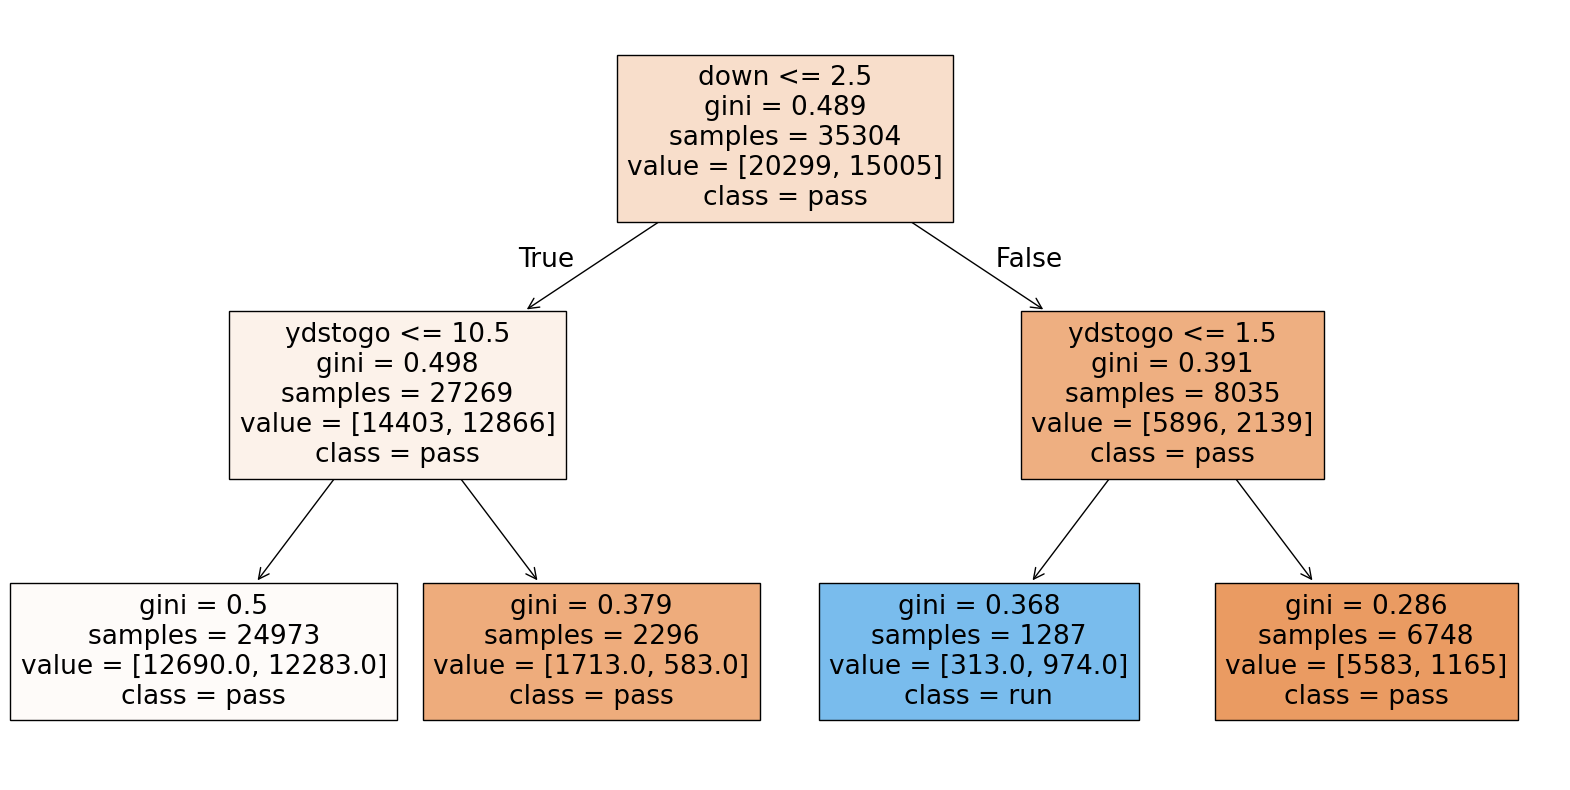

In [81]:
# Prepare features and target
X = plays2[["down", "ydstogo", "yardline_100"]]
y = plays2["play_type"]

# Create and fit the decision tree
clf = tr.DecisionTreeClassifier(max_depth=2, random_state=101)
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(20,10))
tr.plot_tree(clf, feature_names=X.columns, filled=True, class_names=clf.classes_)
plt.show()



### Part (c)

Inspect the graph in the previous step. The boxes will have numbers like `[100, 200]`. This represents the numbers of passes and runs contained in that split, respectively. Use the graph to answer the following questions:

- What variable was used to create the first split? What is the decision made about that variable?
- For a play that is on 3rd down, with 5 yards to go, and on the 50 yard line, what is the predicted outcome?
- For what group of plays is the decision tree most confident in its prediction?




The first split is based on the variable down, and the decision made is:
If down <= 2.5, the decision is "True," and the play is classified as "pass."
If down > 2.5, the decision is "False," and the play continues to another split.
For a play that is on 3rd down, with 5 yards to go, and on the 50-yard line, what is the predicted outcome?

The first split is based on the down variable. Since it's 3rd down, the play will proceed to the "False" side of the first split, where the decision tree considers the ydstogo (yards to go).
For ydstogo <= 1.5, the prediction is "pass."
For ydstogo > 1.5, the prediction is "run."
If the play is 3rd down and 5 yards to go, the ydstogo is greater than 1.5, so the predicted outcome would be "run."
For what group of plays is the decision tree most confident in its prediction?

The decision tree is most confident when the down <= 2.5 and ydstogo <= 10.5. In this case, the Gini index is 0.5, which indicates a high degree of certainty (a Gini index closer to 0 suggests less impurity and more confidence in the classification).
Another sign of high confidence is when the samples in that node are large (such as samples = 24973 in one of the nodes), leading to fewer mistakes in the predictions.




### Part (d)

Now create a tree without a maximum depth. Using the `predict` method, predict the following plays:

In [82]:
plays_to_predict = pd.DataFrame({"down": [1, 2, 3, 4],
                                 "ydstogo": [10, 5, 2, 1],
                                 "yardline_100": [20, 50, 80, 99]})

Use the `predict_proba` method to get the probabilities of each play type for each of these plays. For which of these predictions was the tree most confident? For which was the tree the least confident?


In [83]:
# Create an unrestricted depth tree
clf_full = tr.DecisionTreeClassifier(random_state=101)
clf_full.fit(X, y)

# Plays to predict
plays_to_predict = pd.DataFrame({
    "down": [1, 2, 3, 4],
    "ydstogo": [10, 5, 2, 1],
    "yardline_100": [20, 50, 80, 99]
})

# Predict probabilities
proba_predictions = clf_full.predict_proba(plays_to_predict)

# Display probabilities
print("\nPrediction Probabilities:")
for i, probs in enumerate(proba_predictions):
    print(f"Play {i+1}: {dict(zip(clf_full.classes_, probs))}")


Prediction Probabilities:
Play 1: {'pass': np.float64(0.3644067796610169), 'run': np.float64(0.635593220338983)}
Play 2: {'pass': np.float64(0.4), 'run': np.float64(0.6)}
Play 3: {'pass': np.float64(0.5714285714285714), 'run': np.float64(0.42857142857142855)}
Play 4: {'pass': np.float64(0.0), 'run': np.float64(1.0)}


Play 3 as the closes values thus it is least confident here



### Part (e)

Now, use the `cross_val_score` function from `sklearn.model_selection` to perform a 5-fold cross validation on the data. Use the `DecisionTreeClassifier` with `random_state = 100` and `max_depth = 2`. Print out the mean accuracy of the model. (Larger values are better.)

Repeat this process with a `max_depth = 5`. What do you notice about the accuracy of the model as the depth increases?


In [84]:
from sklearn.model_selection import cross_val_score

# Cross-validation for depth=2
scores_depth2 = cross_val_score(
    tr.DecisionTreeClassifier(max_depth=2, random_state=100), 
    X, y, 
    cv=5
)

# Cross-validation for depth=5
scores_depth5 = cross_val_score(
    tr.DecisionTreeClassifier(max_depth=5, random_state=100), 
    X, y, 
    cv=5
)

print("\nMean Accuracy (Depth=2):", scores_depth2.mean())
print("Mean Accuracy (Depth=5):", scores_depth5.mean())


Mean Accuracy (Depth=2): 0.5977792631030361
Mean Accuracy (Depth=5): 0.6333845569948322


As the depth increases the mean accuracy increases




### Part (f)

Using the `RandomForestClassifier` from `sklearn.ensemble`, fit a random forest model to the data with `n_estimators = 100` and `random_state = 100`. Perform a 5-fold cross validation on the data and print out the mean accuracy of the model. Which technique performs better: decision tree classifiers or random forests?


In [85]:
# Random Forest with 5-fold cross-validation
rf_classifier = ens.RandomForestClassifier(
    n_estimators=100, 
    random_state=100
)

rf_scores = cross_val_score(rf_classifier, X, y, cv=5)
print("\nRandom Forest Mean Accuracy:", rf_scores.mean())


Random Forest Mean Accuracy: 0.6155679503541176


The decision tree has a higher mean accuracy